In [1]:
import autograd.numpy as np  
from autograd import grad, elementwise_grad

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn import datasets
from sklearn.datasets import make_blobs, load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from sklearn.neural_network import MLPClassifier

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

def derivate(func):
    return elementwise_grad(func)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)
    
def binary_cross_entropy(predictions, targets):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)  # Avoid log(0)
    return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))

def binary_cross_entropy_der(predictions, targets):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)  # Avoid division by zero
    return (predictions - targets) / (predictions * (1 - predictions))

def r2_score(predictions, targets):
    ss_total = np.sum((targets - np.mean(targets)) ** 2)
    ss_residual = np.sum((targets - predictions) ** 2)
    return 1 - (ss_residual / ss_total)

def create_layers_batch(network_input_size, layer_output_sizes): 
    layers = []
    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(i_size, layer_output_size) * np.sqrt(2 / (i_size + layer_output_size))
        b = np.zeros(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers

def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = (a @ W) + b
        a = activation_func(z)
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = inputs  
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b  
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a 

def backpropagation_batch(input_batch, layers, activation_funcs, targets,activation_ders, cost_der):
    batch_size = input_batch.shape[0]
    layer_inputs, zs, predict = feed_forward_saver_batch(input_batch, layers, activation_funcs)
    layer_grads = [() for _ in layers]

    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]
        
        if i == len(layers) - 1:
            dC_da = cost_der(predict, targets)
        else:
            (W, b) = layers[i + 1][:2]
            dC_da = dC_dz @ W.T 
        
        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz / batch_size
        dC_db = np.mean(dC_dz, axis=0)
        
        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

def train_nn_classification(inputs, targets, val_inputs, val_targets, layers, activation_funcs, activation_ders, learning_rate=0.001, epochs=100, batch_size=32):
    n_samples = len(inputs)
    training_metrics = {'loss': [], 'accuracy': []}
    validation_metrics = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        inputs_shuffled = inputs[indices]
        targets_shuffled = targets[indices]
        # Mini-batch training
        for i in range(0, n_samples, batch_size):
            batch_inputs = inputs_shuffled[i:i + batch_size]
            batch_targets = targets_shuffled[i:i + batch_size]
            # Compute gradients
            layer_grads = backpropagation_batch(batch_inputs, layers, activation_funcs, batch_targets, activation_ders, binary_cross_entropy_der)
            # Update weights and biases
            for j, ((W, b), (dW, db)) in enumerate(zip(layers, layer_grads)):
                layers[j] = (W - learning_rate * dW, b - learning_rate * db)
                
        if epoch % 10 == 0:
            predictions = feed_forward_batch(inputs, layers, activation_funcs)
            acc = accuracy_score(targets, (predictions > 0.5).astype(int))
            print(f'Epoch {epoch}, Training Accuracy: {acc:.4f}')
        
        # Calculate metrics on training set
        predictions_train = feed_forward_batch(inputs, layers, activation_funcs)
        loss_train = binary_cross_entropy(predictions_train, targets)
        accuracy_train = accuracy_score(targets, (predictions_train > 0.5).astype(int))
        training_metrics['loss'].append(loss_train)
        training_metrics['accuracy'].append(accuracy_train)

        # Calculate metrics on validation set
        predictions_val = feed_forward_batch(val_inputs, layers, activation_funcs)
        loss_val = binary_cross_entropy(predictions_val, val_targets)
        accuracy_val = accuracy_score(val_targets, (predictions_val > 0.5).astype(int))
        validation_metrics['loss'].append(loss_val)
        validation_metrics['accuracy'].append(accuracy_val)

    return layers, training_metrics, validation_metrics

In [3]:
np.random.seed(32)
# Load and prepare data
data = load_breast_cancer()
X = data.data 
y = data.target

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert y_train and y_test to one-hot encoding for compatibility 
y_train_onehot = np.eye(2)[y_train]
y_val_onehot = np.eye(2)[y_val]

# Network configuration
input_size = X_train.shape[1]
layer_output_sizes = [4, 2]  # Output layer has 2 neurons for binary classification 
activation_funcs = [sigmoid, sigmoid]
activation_ders = [sigmoid_der, sigmoid_der]

# Create layers
layers = create_layers_batch(input_size, layer_output_sizes)

# Get initial predictions and accuracy
initial_predictions = feed_forward_batch(X_val, layers, activation_funcs)
initial_pred_classes = np.argmax(initial_predictions, axis=1) 
initial_acc = accuracy_score(y_val, initial_pred_classes)
print(f'Initial accuracy before training: {initial_acc:.4f}')

# Confusion matrix before training
initial_conf_matrix = confusion_matrix(y_val, initial_pred_classes)
print("\nConfusion Matrix before training on validation:")
print(initial_conf_matrix)

# Train the network
layers, training_metrics, validation_metrics = train_nn_classification(X_train, y_train_onehot, X_val, y_val_onehot, layers, activation_funcs, activation_ders, learning_rate=0.01, epochs=100, batch_size=32)

# Get final predictions and accuracy
final_predictions = feed_forward_batch(X_val, layers, activation_funcs)
final_pred_classes = np.argmax(final_predictions, axis=1) 
final_acc = accuracy_score(y_val, final_pred_classes)
print(f'\nFinal accuracy after training on validation: {final_acc:.4f}')

# Confusion matrix after training
final_conf_matrix = confusion_matrix(y_val, final_pred_classes)
print("\nConfusion Matrix after training on validation:")
print(final_conf_matrix)

Initial accuracy before training: 0.4176

Confusion Matrix before training on validation:
[[36  0]
 [53  2]]
Epoch 0, Training Accuracy: 0.3599
Epoch 10, Training Accuracy: 0.8791
Epoch 20, Training Accuracy: 0.9176
Epoch 30, Training Accuracy: 0.9258
Epoch 40, Training Accuracy: 0.9341
Epoch 50, Training Accuracy: 0.9478
Epoch 60, Training Accuracy: 0.9505
Epoch 70, Training Accuracy: 0.9560
Epoch 80, Training Accuracy: 0.9615
Epoch 90, Training Accuracy: 0.9643

Final accuracy after training on validation: 0.9560

Confusion Matrix after training on validation:
[[33  3]
 [ 1 54]]


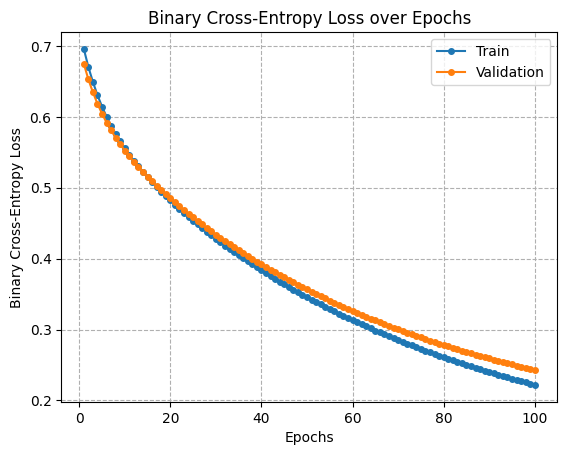

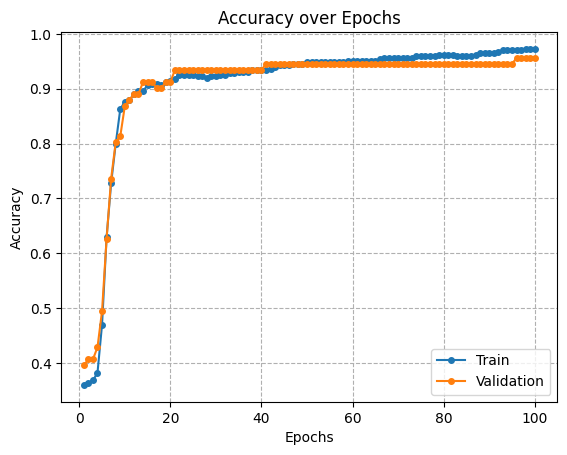

In [4]:
# Plot training and validation loss
plt.plot(range(1, len(training_metrics['loss']) + 1), training_metrics['loss'], label='Train', marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics['loss']) + 1), validation_metrics['loss'], label='Validation', marker='o', markersize=4)
plt.title('Binary Cross-Entropy Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, len(training_metrics['accuracy']) + 1), training_metrics['accuracy'], label='Train', marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics['accuracy']) + 1), validation_metrics['accuracy'], label='Validation', marker='o', markersize=4)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

### Test

In [5]:
# Get final predictions and accuracy
final_predictions = feed_forward_batch(X_test, layers, activation_funcs)
final_pred_classes = np.argmax(final_predictions, axis=1)  # Convert to class labels
final_acc = accuracy_score(y_test, final_pred_classes)
print(f'\nFinal accuracy after training on validation: {final_acc:.4f}')

# Confusion matrix after training
final_conf_matrix = confusion_matrix(y_test, final_pred_classes)
print("\nConfusion Matrix after training on validation:")
print(final_conf_matrix)


Final accuracy after training on validation: 0.3772

Confusion Matrix after training on validation:
[[43  0]
 [71  0]]


/home/laura/.local/lib/python3.12/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [6]:
# Scikit
mlp_clf = MLPClassifier(hidden_layer_sizes=(4,), activation='logistic', max_iter=1000, learning_rate_init=0.01, solver='sgd', random_state=32)

mlp_clf.fit(X_train, y_train)

# Validation
final_predictions_val = mlp_clf.predict(X_val)
final_acc_val = accuracy_score(y_val, final_predictions_val)
print(f'\nFinal accuracy on validation set after training: {final_acc_val:.4f}')

# Confusion matrix 
final_conf_matrix_val = confusion_matrix(y_val, final_predictions_val)
print("\nFinal Confusion Matrix on validation set:")
print(final_conf_matrix_val)

# Test
final_predictions_val = mlp_clf.predict(X_test)
final_acc_val = accuracy_score(y_test, final_predictions_val)
print(f'\nFinal accuracy on test set after training: {final_acc_val:.4f}')

# Confusion matrix 
final_conf_matrix_val = confusion_matrix(y_test, final_predictions_val)
print("\nFinal Confusion Matrix on test set:")
print(final_conf_matrix_val)


Final accuracy on validation set after training: 0.9670

Final Confusion Matrix on validation set:
[[34  2]
 [ 1 54]]

Final accuracy on test set after training: 0.3772

Final Confusion Matrix on test set:
[[43  0]
 [71  0]]
